In [1]:
# This file is part of the pyMOR project (http://www.pymor.org).
# Copyright 2013-2019 pyMOR developers and contributors. All rights reserved.
# License: BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)

Simplified version of the thermalblock demo
=====================================

In [2]:
from pymor.basic import *        # most common pyMOR functions and classes

# parameters for high-dimensional models
NGS_ORDER = 4
%matplotlib inline

High-dimensional model
------------------------------------

In [3]:
def _setup_mesh():
    from netgen.csg import CSGeometry, OrthoBrick, Pnt
    from ngsolve import (ngsglobals, Mesh)
    ngsglobals.msg_level = 1
    
    geo = CSGeometry()
    obox = OrthoBrick(Pnt(-1, -1, -1), Pnt(1, 1, 1)).bc("outer")

    b = []
    b.append(OrthoBrick(Pnt(-1, -1, -1), Pnt(0.0, 0.0, 0.0)).mat("mat1").bc("inner"))
    b.append(OrthoBrick(Pnt(-1,  0, -1), Pnt(0.0, 1.0, 0.0)).mat("mat2").bc("inner"))
    b.append(OrthoBrick(Pnt(0,  -1, -1), Pnt(1.0, 0.0, 0.0)).mat("mat3").bc("inner"))
    b.append(OrthoBrick(Pnt(0,   0, -1), Pnt(1.0, 1.0, 0.0)).mat("mat4").bc("inner"))
    b.append(OrthoBrick(Pnt(-1, -1,  0), Pnt(0.0, 0.0, 1.0)).mat("mat5").bc("inner"))
    b.append(OrthoBrick(Pnt(-1,  0,  0), Pnt(0.0, 1.0, 1.0)).mat("mat6").bc("inner"))
    b.append(OrthoBrick(Pnt(0,  -1,  0), Pnt(1.0, 0.0, 1.0)).mat("mat7").bc("inner"))
    b.append(OrthoBrick(Pnt(0,   0,  0), Pnt(1.0, 1.0, 1.0)).mat("mat8").bc("inner"))
    box = (obox - b[0] - b[1] - b[2] - b[3] - b[4] - b[5] - b[6] - b[7])

    geo.Add(box)
    for bi in b:
        geo.Add(bi)
    # domain 0 is empty!

    return Mesh(geo.GenerateMesh(maxh=0.3))

def discretize_ngsolve():
    from ngsolve import (ngsglobals, H1, CoefficientFunction, LinearForm, SymbolicLFI,
                         BilinearForm, SymbolicBFI, grad, TaskManager)
    import numpy as np

    mesh = _setup_mesh()

    # H1-conforming finite element space
    V = H1(mesh, order=NGS_ORDER, dirichlet="outer")
    v = V.TestFunction()
    u = V.TrialFunction()

    # Coeff as array: variable coefficient function (one CoefFct. per domain):
    sourcefct = CoefficientFunction([1 for i in range(9)])

    with TaskManager():
        # the right hand side
        f = LinearForm(V)
        f += SymbolicLFI(sourcefct * v)
        f.Assemble()

        # the bilinear-form
        mats = []
        coeffs = [[0, 1, 0, 0, 0, 0, 0, 0, 1],
                  [0, 0, 1, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 1, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1, 0, 0, 0]]
        for c in coeffs:
            diffusion = CoefficientFunction(c)
            a = BilinearForm(V, symmetric=False)
            a += SymbolicBFI(diffusion * grad(u) * grad(v), definedon=(np.where(np.array(c) == 1)[0] + 1).tolist())
            a.Assemble()
            mats.append(a.mat)

    from pymor.bindings.ngsolve import NGSolveVectorSpace, NGSolveMatrixOperator, NGSolveVisualizer

    space = NGSolveVectorSpace(V)
    op = LincombOperator([NGSolveMatrixOperator(m, space, space) for m in mats],
                         [ProjectionParameterFunctional('diffusion', (len(coeffs),), (i,)) for i in range(len(coeffs))])

    h1_0_op = op.assemble([1] * len(coeffs)).with_(name='h1_0_semi')

    F = space.zeros()
    F._list[0].impl.vec.data = f.vec
    F = VectorOperator(F)

    return StationaryModel(op, F, visualizer=NGSolveVisualizer(mesh, V),
                           products={'h1_0_semi': h1_0_op},
                           parameter_space=CubicParameterSpace(op.parameter_type, 0.1, 1.))


Reduction algorithms
--------------------------------

In [4]:
def reduce_naive(fom, reductor, basis_size):

    training_set = fom.parameter_space.sample_randomly(basis_size)

    for mu in training_set:
        reductor.extend_basis(fom.solve(mu), method='trivial')

    rom = reductor.reduce()

    return rom


def reduce_greedy(fom, reductor, snapshots, basis_size):

    training_set = fom.parameter_space.sample_uniformly(snapshots)
    pool = new_parallel_pool()

    greedy_data = greedy(fom, reductor, training_set,
                         extension_params={'method': 'gram_schmidt'},
                         max_extensions=basis_size,
                         pool=pool)

    return greedy_data['rom']


def reduce_adaptive_greedy(fom, reductor, validation_mus, basis_size):

    pool = new_parallel_pool()

    greedy_data = adaptive_greedy(fom, reductor, validation_mus=-validation_mus,
                                  extension_params={'method': 'gram_schmidt'},
                                  max_extensions=basis_size,
                                  pool=pool)

    return greedy_data['rom']


def reduce_pod(fom, reductor, snapshots, basis_size):

    training_set = fom.parameter_space.sample_uniformly(snapshots)

    snapshots = fom.operator.source.empty()
    for mu in training_set:
        snapshots.append(fom.solve(mu))

    basis, singular_values = pod(snapshots, modes=basis_size, product=reductor.product)
    reductor.extend_basis(basis, method='trivial')

    rom = reductor.reduce()

    return rom

## Main script


 - *ALG* The model reduction algorithm to use (naive, greedy, adaptive_greedy, pod).

 - *SNAPSHOTS*: 
     - naive: ignored
     - greedy/pod:      Number of training_set parameters per block
                          (in total SNAPSHOTS^(XBLOCKS * YBLOCKS)
                          parameters).

     - adaptive_greedy: size of validation set.
 - *RBSIZE* Size of the reduced basis.

 - *TEST* Number of parameters for stochastic error estimation.


Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

.....


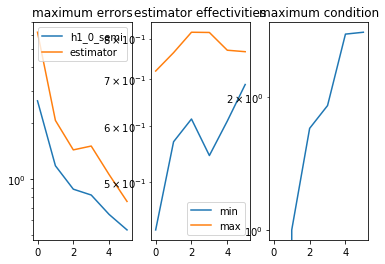

In [5]:
ALG = "greedy"
SNAPSHOTS = 5
RBSIZE = 5
TEST = 5

fom = discretize_ngsolve()
# select reduction algorithm with error estimator
#################################################
coercivity_estimator = ExpressionParameterFunctional('min(diffusion)', fom.parameter_type)
reductor = CoerciveRBReductor(fom, product=fom.h1_0_semi_product, coercivity_estimator=coercivity_estimator,
                              check_orthonormality=False)

# generate reduced model
########################
if ALG == 'naive':
    rom = reduce_naive(fom, reductor, RBSIZE)
elif ALG == 'greedy':
    rom = reduce_greedy(fom, reductor, SNAPSHOTS, RBSIZE)
elif ALG == 'adaptive_greedy':
    rom = reduce_adaptive_greedy(fom, reductor, SNAPSHOTS, RBSIZE)
elif ALG == 'pod':
    rom = reduce_pod(fom, reductor, SNAPSHOTS, RBSIZE)
else:
    raise NotImplementedError

# evaluate the reduction error
##############################
results = reduction_error_analysis(rom, fom=fom, reductor=reductor, estimator=True,
                                   error_norms=[fom.h1_0_semi_norm], condition=True,
                                   test_mus=TEST, random_seed=999, plot=True)

In [6]:
# show results
##############
print(results['summary'])
import matplotlib.pyplot
matplotlib.pyplot.show(results['figure'])


# visualize reduction error for worst-approximated mu
#####################################################
mumax = results['max_error_mus'][0, -1]
U = fom.solve(mumax)
U_RB = reductor.reconstruct(rom.solve(mumax))
# This only works with real X Display access
fom.visualize((U, U_RB, U - U_RB), legend=('Detailed Solution', 'Reduced Solution', 'Error'),
              separate_colorbars=True, block=True)


Stochastic error estimation:
    number of samples:                5
    maximum h1_0_semi-norm:           2.6397043e+00 (mu = {diffusion: [0.40849340646943433, 0.2814036497339801, 0.7365918070918953, 0.1300593379224498]})
    maximum h1_0_semi-error:          5.3305354e-01 (mu = {diffusion: [0.40849340646943433, 0.2814036497339801, 0.7365918070918953, 0.1300593379224498]})
    maximum estimated error:          7.5875891e-01 (mu = {diffusion: [0.40849340646943433, 0.2814036497339801, 0.7365918070918953, 0.1300593379224498]})
    minimum estimator effectivity:    6.8810565e-01 (mu = {diffusion: [0.9183250392472524, 0.46464459839419614, 0.7843919233053798, 0.5263825381853718]})
    maximum estimator effectivity:    7.6632301e-01 (mu = {diffusion: [0.6653138702298047, 0.7276536497749134, 0.8109547199932422, 0.21870131760514833]})
    maximum system matrix condition:  2.8121652e+00 (mu = {diffusion: [0.40849340646943433, 0.2814036497339801, 0.7365918070918953, 0.1300593379224498]})
    ela

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…